In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import torch
import torch.nn as nn
import torch.optim as optim
import os
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from transformers import pipeline, AutoTokenizer, AutoModelForSeq2SeqLM
from diffusers import StableDiffusionPipeline


RANDOM_STATE = 37
np.random.seed(RANDOM_STATE)
torch.manual_seed(RANDOM_STATE)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(RANDOM_STATE)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

Device: cuda


Генерація тексту (RNN)

In [18]:
filename = "Lys_mykyta.txt"
seq_length = 40
step = 1
batch_size = 256
epochs = 50
hidden_size = 512
layers = 2
lr = 0.002

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Завантаження тексту
with open(filename, 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
char_to_int = {c: i for i, c in enumerate(chars)}
int_to_char = {i: c for i, c in enumerate(chars)}
n_vocab = len(chars)

print(f"Словник: {n_vocab} символів")

# Підготовка даних
dataX = []
dataY = []

for i in range(0, len(text) - seq_length, step):
    seq_in = text[i:i + seq_length]
    seq_out = text[i + seq_length]
    dataX.append([char_to_int[char] for char in seq_in])
    dataY.append(char_to_int[seq_out])

print(f"Кількість прикладів: {len(dataX)}")

# Перетворення в тензори
X = torch.tensor(dataX, dtype=torch.long)
y = torch.tensor(dataY, dtype=torch.long)

dataset = TensorDataset(X, y)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Модель з Embedding
class LSTMModel(nn.Module):
    def __init__(self):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(n_vocab, hidden_size // 2)
        self.lstm = nn.LSTM(hidden_size // 2, hidden_size, num_layers=layers, batch_first=True, dropout=0.3)
        self.fc = nn.Linear(hidden_size, n_vocab)

    def forward(self, x):
        embeds = self.embedding(x)
        out, _ = self.lstm(embeds)
        out = self.fc(out[:, -1, :])
        return out

model = LSTMModel().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Навчання
for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    for batch_X, batch_y in dataloader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)

        optimizer.zero_grad()
        output = model(batch_X)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs} | Loss: {epoch_loss/len(dataloader):.4f}")

# Генерація
def generate(start_str, length=300):
    model.eval()
    if len(start_str) < seq_length:
        start_str = start_str.rjust(seq_length)
    else:
        start_str = start_str[-seq_length:]

    pattern = [char_to_int.get(c, 0) for c in start_str]
    print(f"\nВхідні дані: ...{start_str}")
    print("Результат: ", end="")

    with torch.no_grad():
        for _ in range(length):
            x = torch.tensor(pattern, dtype=torch.long).reshape(1, seq_length).to(device)
            output = model(x)

            # Температура 0.5 для кращої читабельності
            output = output / 0.5
            probs = torch.softmax(output, dim=1).cpu().numpy()[0]
            index = np.random.choice(len(probs), p=probs)

            char = int_to_char[index]
            print(char, end="")

            pattern.append(index)
            pattern = pattern[1:]
    print()

generate("Хто ж се, хто? — гукає знову")

Словник: 80 символів
Кількість прикладів: 86486
Epoch 10/50 | Loss: 1.4153
Epoch 20/50 | Loss: 1.0073
Epoch 30/50 | Loss: 0.7888
Epoch 40/50 | Loss: 0.7098
Epoch 50/50 | Loss: 0.6801

Вхідні дані: ...            Хто ж се, хто? — гукає знову
Результат:  з воза,
Про такі слова сказать,
Щоб вікно відплату – татка,
Чом не бачу скарб співаєш?
Чи ще й шкоду нам треба
Сил, м'яса, коло тебе.
Думав я, що курка скраю,
Чи від себе віддасть.

От Медвідь – мій куди й болю.
Пригоду розповівши,
Ковби поїсти – далі, в цю мить?

Кіт Мурлика за звірам!

– Що це, б


Розроблений програмний код реалізує модель генерації тексту на основі архітектури LSTM із використанням шару Embedding, що дозволило ефективно обробляти текстові послідовності на рівні символів. Завдяки зменшенню кроку зсуву вікна вдалося значно збільшити обсяг навчальних даних, а двошарова структура мережі забезпечила стабільне навчання та зниження функції втрат до рівня 0.6801. результати свідчать про те, що модель успішно засвоїла структуру українських слів та загальну стилістику  Франка. Згенерований текст зберігає віршований ритм, містить коректні імена персонажів та переважно реальні лексичні одиниці, уникаючи вигаданих буквосполучень. Попри те що глибинна смислова зв'язність речень залишається частковою через специфіку посимвольного навчання, нейромережа продемонструвала здатність формувати локальні граматичні конструкції та відтворювати пунктуаційні особливості оригінального твору.

Генерація зображень (DCGAN на FashionMNIST)


Навчання GAN...
Epoch 1/5 | D Loss: 0.3060 | G Loss: 7.8425
Epoch 2/5 | D Loss: 0.2550 | G Loss: 2.6127
Epoch 3/5 | D Loss: 0.3192 | G Loss: 3.3359
Epoch 4/5 | D Loss: 0.3087 | G Loss: 3.6434
Epoch 5/5 | D Loss: 0.5921 | G Loss: 2.4932


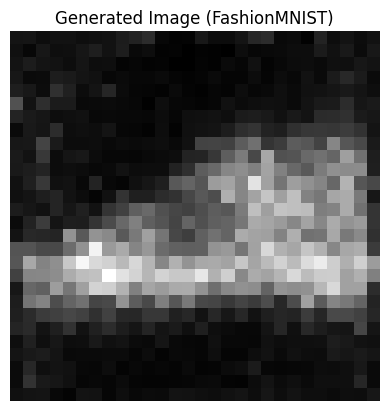

In [31]:
batch_size = 64
z_dim = 100
lr = 0.0002

# Завантаження FashionMNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)


class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(True),
            nn.Linear(256, 512),
            nn.ReLU(True),
            nn.Linear(512, 1024),
            nn.ReLU(True),
            nn.Linear(1024, 28*28),
            nn.Tanh()
        )
    def forward(self, x):
        return self.main(x).view(-1, 1, 28, 28)


class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        x = x.view(-1, 28*28)
        return self.main(x)

G = Generator().to(device)
D = Discriminator().to(device)

opt_G = optim.Adam(G.parameters(), lr=lr)
opt_D = optim.Adam(D.parameters(), lr=lr)
criterion = nn.BCELoss()

# Навчання
print("\nНавчання GAN...")
epochs = 5
for epoch in range(epochs):
    for i, (imgs, _) in enumerate(dataloader):
        real_imgs = imgs.to(device)
        batch_size = real_imgs.size(0)

        # Навчання Дискримінатора
        opt_D.zero_grad()
        labels_real = torch.ones(batch_size, 1).to(device)
        labels_fake = torch.zeros(batch_size, 1).to(device)

        outputs = D(real_imgs)
        d_loss_real = criterion(outputs, labels_real)

        z = torch.randn(batch_size, z_dim).to(device)
        fake_imgs = G(z)
        outputs = D(fake_imgs.detach())
        d_loss_fake = criterion(outputs, labels_fake)

        d_loss = d_loss_real + d_loss_fake
        d_loss.backward()
        opt_D.step()

        # Навчання Генератора
        opt_G.zero_grad()
        outputs = D(fake_imgs)
        g_loss = criterion(outputs, labels_real)
        g_loss.backward()
        opt_G.step()

    print(f"Epoch {epoch+1}/{epochs} | D Loss: {d_loss.item():.4f} | G Loss: {g_loss.item():.4f}")

# Візуалізація результату
z = torch.randn(1, z_dim).to(device)
gen_img = G(z).cpu().detach().numpy().reshape(28, 28)
plt.imshow(gen_img, cmap='gray')
plt.title("Generated Image (FashionMNIST)")
plt.axis('off')
plt.show()

Втрати обох мереж не падають до нуля і постійно змінюються, свідчить про ефективну конкуренцію: дискримінатор вчиться відрізняти реальні зображення від фейкових, змушуючи генератор покращувати свої результати, щоб «обдурити» опонента. Результатом роботи є згенероване зображення розміром 28x28 пікселів, на якому можна розпізнати силует взуття, що відповідає одному з класів FashionMNIST.

 Експерименти з моделями бібліотеки Hugging Face

--- 3.b Summarization UKR ---


Device set to use cuda


Оригінал: 628 символів
Сумаризація: Сонце — одна з найбільших енергетичних ресурсів світу.

--- 3.b Translation EN->UKR ---


Device set to use cuda


EN: Deep learning models have revolutionized computer vision and natural language processing.
UKR: Моделі глибокого навчання революціонували комп'ютерне бачення та природну мову.

--- 3.b Zero-shot класифікація (UKR) ---


Device set to use cuda


Текст: Ціни на нафту різко впали після засідання ОПЕК.
Категорія: економіка (Впевненість: 0.7280)

--- 3.c Генерація зображення (Stable Diffusion) ---


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

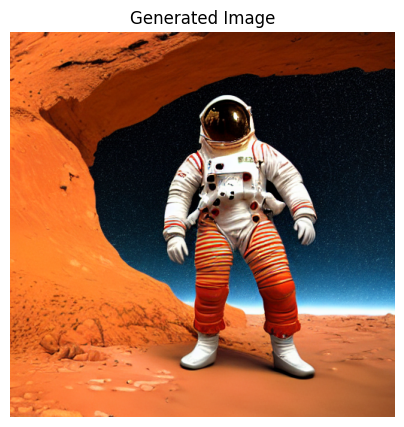

In [29]:
print("--- 3.b Summarization UKR ---")
# Використовуємо mT5 - мультимовну модель, що підтримує українську
summarizer = pipeline("summarization", model="csebuetnlp/mT5_multilingual_XLSum", device=device)
ukr_long_text = """Сонце — центральне і наймасивніше тіло Сонячної системи, типова зоря головної послідовності спектрального класу G2. Його маса приблизно в 333 000 разів більша за масу Землі, у 750 разів перевищує масу всіх інших планет, разом узятих, та становить 99,866 % від загальної маси всієї Сонячної системи[21]. Сонце — потужне джерело енергії, яку постійно випромінює в усіх ділянках спектра електромагнітних хвиль — від рентгенівських і ультрафіолетових променів до радіохвиль. Це випромінювання впливає на всі тіла Сонячної системи: нагріває їх, позначається на атмосферах планет, дає світло й тепло, необхідні для життя на Землі[22]."""
summary = summarizer(ukr_long_text, max_length=50, min_length=10, do_sample=False)
print(f"Оригінал: {len(ukr_long_text)} символів")
print(f"Сумаризація: {summary[0]['summary_text']}\n")


print("--- 3.b Translation EN->UKR ---")
translator = pipeline("translation", model="Helsinki-NLP/opus-mt-en-uk", device=device)
text_en = "Deep learning models have revolutionized computer vision and natural language processing."
trans_res = translator(text_en)
print(f"EN: {text_en}")
print(f"UKR: {trans_res[0]['translation_text']}\n")


print("--- 3.b Zero-shot класифікація (UKR) ---")
classifier = pipeline("zero-shot-classification", model="MoritzLaurer/mDeBERTa-v3-base-mnli-xnli", device=device)
text_classify = "Ціни на нафту різко впали після засідання ОПЕК."
labels = ["економіка", "спорт", "медицина", "кіно"]
class_res = classifier(text_classify, labels)
print(f"Текст: {text_classify}")
print(f"Категорія: {class_res['labels'][0]} (Впевненість: {class_res['scores'][0]:.4f})\n")



print("--- 3.c Генерація зображення (Stable Diffusion) ---")

# Використовуємо float16 для економії пам'яті
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16)
pipe = pipe.to(device)
# Вимикаємо фільтр безпеки, щоб уникнути помилок чорного екрану
pipe.safety_checker = None

prompt = "A highly detailed photograph of a lone astronaut in a spacesuit standing on the red rocky surface of Mars. The astronaut is looking upwards at the dark night sky filled with billions of bright stars and the Milky Way. Cinematic lighting, sharp focus, hyperrealistic, 8k resolution, vivid colors."
image = pipe(prompt).images[0]

plt.figure(figsize=(5, 5))
plt.imshow(image)
plt.axis("off")
plt.title("Generated Image")
plt.show()